# D. Journic's Phase 2 Project

My first attempt at a notebook started to look more and more like a trainwreck made of nightmares. This is where I will clean it up and make it presentable.

## The Business Problem:
Given a certain housing dataset, form a nice linear model from the variables you desire. In this case, I want to make a kind of CarFax for houses: where a potential buyer can input the square footage in the house, and in the lot, the number of bedrooms and the number of bathrooms and my model will give them a price (hopefully a fair one).
The reason I chose these and not others was from a brief survey I conducted on my own neighbors, these were the four items they mentioned that were in the data; there were others (proximity to schools, restaurants, etc) but these were the criteria that was included in the data given.

Now that we have some idea what we want to do, let's get to it. Start by importing all the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
# Setting random seed for reproducibility, not sure if I'll need it.
np.random.seed(1000)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import eli5

In [2]:
#Next, read the data
df=pd.read_csv("kc_house_data.csv")

In [3]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [4]:
#The target variable is price.
price=df['price']

I know the variables I want to use for my data, so I can get rid of all the others.

In [5]:
col_ign=['id','date','view','sqft_above','sqft_basement','yr_renovated','zipcode','lat','long','sqft_living15','sqft_lot15','floors','waterfront','condition','grade','yr_built']

In [6]:
df_s1=df.drop(columns=col_ign,axis=1)

In [7]:
price=df_s1['price'] #updating the target variable

In [8]:
df_s1

,price,bedrooms,bathrooms,sqft_living,sqft_lot
0,221900.0,3,1.00,1180,5650
1,538000.0,3,2.25,2570,7242
2,180000.0,2,1.00,770,10000
3,604000.0,4,3.00,1960,5000
4,510000.0,3,2.00,1680,8080
...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131
21593,400000.0,4,2.50,2310,5813
21594,402101.0,2,0.75,1020,1350
21595,400000.0,3,2.50,1600,2388


Let's take a look at the relationships between them

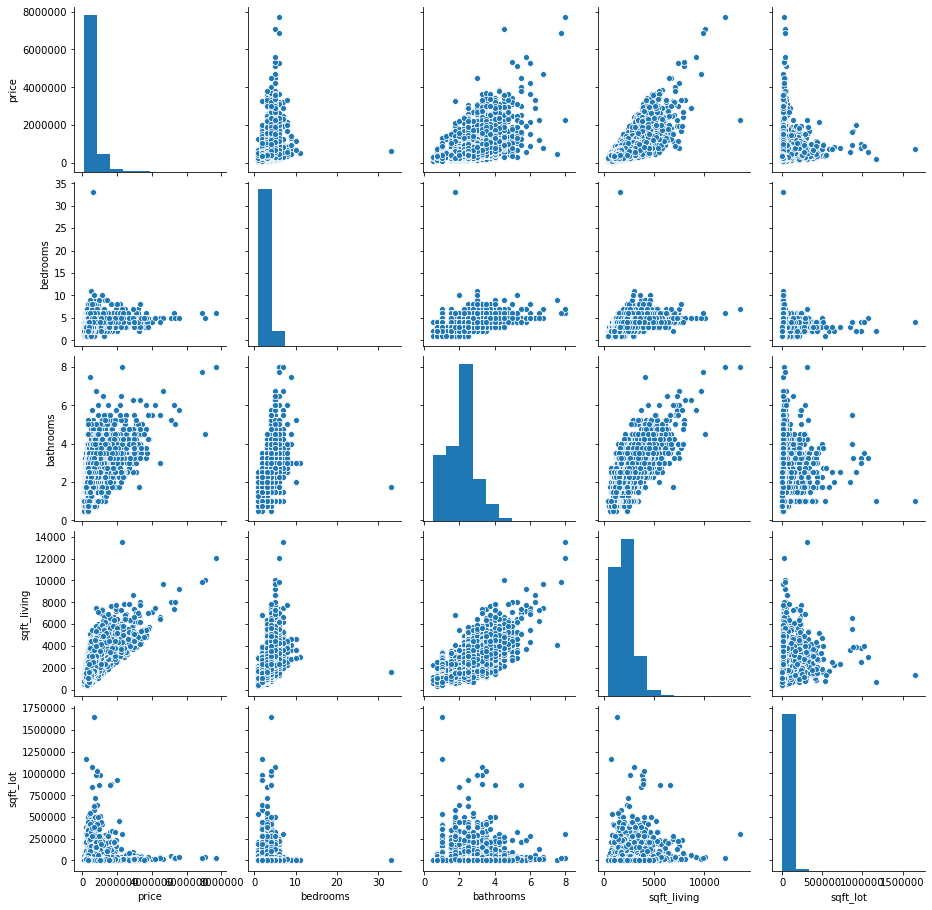

In [9]:
sns.pairplot(df_s1)

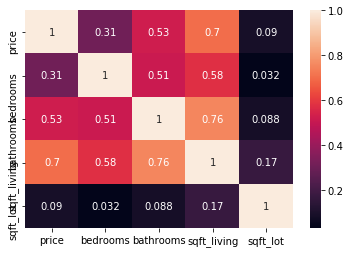

In [10]:
ax = sns.heatmap(df_s1.corr(), annot=True)

ax.set_ylim(5,0)
plt.show()

So I noticed 1 particular outlier, in the bedrooms. One of the entries has 33 bedrooms. That will seriously mess up any model I create, so I'm dropping it.

In [11]:
df_s1 = df_s1[df_s1.bedrooms != 33]

So, this being a linear regression project, I see myself doing many linear regressions. To avoid repetitive code, I'll write a function.

In [12]:
def lreg (elements,target):
    """This function is designed to take in 2 dataframes: the elements and the target. It will then perform a linear
    regression of the variables, and print out the values of the slope (m), intercept (b), as well as the R2 score. It will also
    return those three variables.
    """
    lr=LinearRegression()
    X=elements.values
    y=target.values
    lr.fit(X,y)
    m = lr.coef_
    print('Slope: {}'.format(m))
    b = lr.intercept_
    print('Intercept: {}'.format(b))
    preds = lr.predict(X)
    r2 = r2_score(y, preds)
    print('R2 score: {}'.format(r2))
    
    return m,b,r2

Let's run it through a simple test:

In [13]:
lreg(df_s1[['sqft_living']],df_s1['price'])

Slope: [280.86880525]
Intercept: -44011.542633763864
R2 score: 0.4927041609539141


(array([280.86880525]), -44011.542633763864, 0.4927041609539141)

Success. So let's look at a model of the 4 variables I had picked earlier.

In [14]:
att1=['sqft_living','sqft_lot','bedrooms','bathrooms']

In [16]:
price=df_s1['price']

In [17]:
lreg(df_s1[att1],price)

Slope: [ 3.17701703e+02 -3.87937456e-01 -6.55939211e+04  7.13655709e+03]
Intercept: 91292.7710924244
R2 score: 0.5102382172847046


(array([ 3.17701703e+02, -3.87937456e-01, -6.55939211e+04,  7.13655709e+03]),
 91292.7710924244,
 0.5102382172847046)

Now let's look at some things we can try to improve that R2 number. We saw from the pairplot that there isn't a very good distribution of the price. Let's look at it again, and see what we can do.

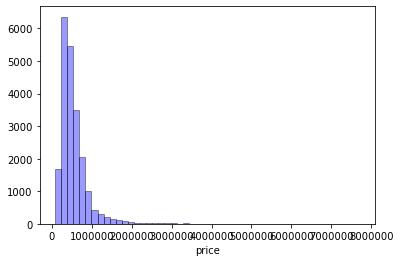

In [18]:
sns.distplot(df_s1['price'], hist=True, kde=False, 
             bins=int(50), color = 'blue',
             hist_kws={'edgecolor':'black'})

Let's try a simple log transform:

In [19]:
price_log=np.log(price)

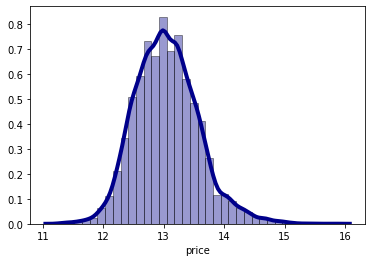

In [20]:
sns.distplot(price_log, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Another thing that can be done: cut off the price a bit. We can set the max to be 2 standard deviations from the log mean. This way only the extremely expensive houses will be cut out.

In [21]:
price_log.describe()

count    21596.000000
mean        13.048196
std          0.526562
min         11.264464
25%         12.682307
50%         13.017003
75%         13.377006
max         15.856731
Name: price, dtype: float64

In [22]:
price_log

0        12.309982
1        13.195614
2        12.100712
3        13.311329
4        13.142166
           ...    
21592    12.793859
21593    12.899220
21594    12.904459
21595    12.899220
21596    12.691580
Name: price, Length: 21596, dtype: float64

In [23]:
stdv=0.526562
cutoff=price_log.mean() + (stdv*2)
price_top=np.exp(cutoff)
print(price_top)

1330838.9322642826


The cutoff is 1.33 Million, that seems like a good top.

In [24]:
df_low1=df_s1[df_s1.price<=1330840]

In [25]:
df_low1.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot
0,221900.0,3,1.00,1180,5650
1,538000.0,3,2.25,2570,7242
2,180000.0,2,1.00,770,10000
3,604000.0,4,3.00,1960,5000
4,510000.0,3,2.00,1680,8080


In [26]:
price=df_low1['price'] #updating the target variable

Let's try our first model again, but with the revised price data. I don't expect much of a change if any.

In [27]:
lreg(df_low1[att1],price)

Slope: [ 2.00084338e+02 -1.26130731e-01 -3.11301011e+04  1.05074290e+04]
Intercept: 175000.13342278852
R2 score: 0.4245556844227749


(array([ 2.00084338e+02, -1.26130731e-01, -3.11301011e+04,  1.05074290e+04]),
 175000.13342278852,
 0.4245556844227749)

So it got worse. Let's look at the distributions of my other variables, see if something can be done.

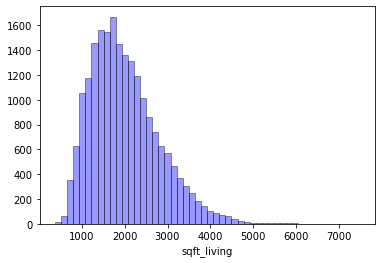

In [28]:
sns.distplot(df_low1['sqft_living'], hist=True, kde=False, 
             bins=int(50), color = 'blue',
             hist_kws={'edgecolor':'black'})

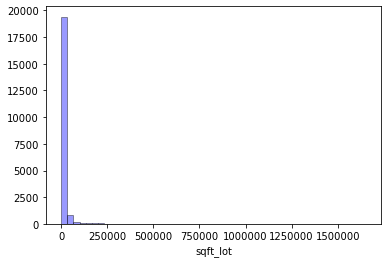

In [29]:
sns.distplot(df_low1['sqft_lot'], hist=True, kde=False, 
             bins=int(50), color = 'blue',
             hist_kws={'edgecolor':'black'})

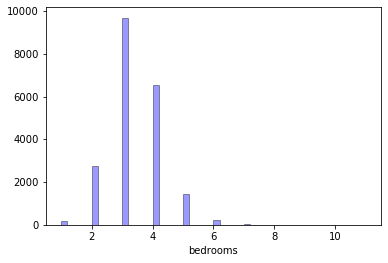

In [30]:
sns.distplot(df_low1['bedrooms'], hist=True, kde=False, 
             bins=int(50), color = 'blue',
             hist_kws={'edgecolor':'black'})

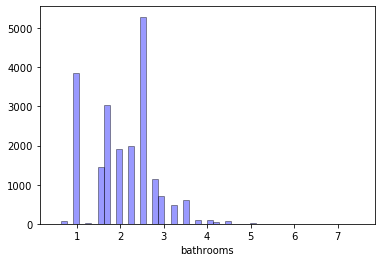

In [31]:
sns.distplot(df_low1['bathrooms'], hist=True, kde=False, 
             bins=int(50), color = 'blue',
             hist_kws={'edgecolor':'black'})

Sqft_iving and sqft_lot could probably use a log transform. Bedrooms actually, kind of looks normal, bathrooms is an absolute mess. Since we're doing some more log transforms, I'm going to add the price_log to the dataframe.

In [32]:
continuous = ['sqft_living', 'sqft_lot','price']
cont = df_low1[continuous]
log_names = [f'{column}_log' for column in cont.columns]
df_log = np.log(cont)
df_log.columns = log_names

In [33]:
df_log

,sqft_living_log,sqft_lot_log,price_log
0,7.073270,8.639411,12.309982
1,7.851661,8.887653,13.195614
2,6.646391,9.210340,12.100712
3,7.580700,8.517193,13.311329
4,7.426549,8.997147,13.142166
...,...,...,...
21592,7.333023,7.030857,12.793859
21593,7.745003,8.667852,12.899220
21594,6.927558,7.207860,12.904459
21595,7.377759,7.778211,12.899220


In [34]:
scaler = StandardScaler()
df_log_norm = scaler.fit_transform(df_log)

In [35]:
df_log_norm = pd.DataFrame(df_log_norm, columns = df_log.columns)

In [36]:
df_pre = pd.concat([df_log_norm, df_low1], axis=1)
df_pre.head()

,sqft_living_log,sqft_lot_log,price_log,price,bedrooms,bathrooms,sqft_living,sqft_lot
0,-1.117789,-0.368636,-1.485162,221900.0,3.0,1.00,1180.0,5650.0
1,0.810548,-0.091637,0.420131,538000.0,3.0,2.25,2570.0,7242.0
2,-2.175311,0.268433,-1.935373,180000.0,2.0,1.00,770.0,10000.0
3,0.139286,-0.505012,0.669074,604000.0,4.0,3.00,1960.0,5000.0
4,-0.242597,0.030542,0.305147,510000.0,3.0,2.00,1680.0,8080.0


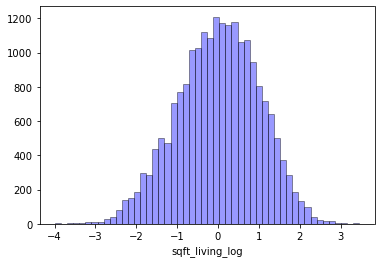

In [37]:
sns.distplot(df_pre['sqft_living_log'], hist=True, kde=False, 
             bins=int(50), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [38]:
att3=['sqft_living_log','sqft_lot_log']

In [39]:
df_pre.dropna(inplace=True) #Getting rid of null values

In [40]:
lreg(df_pre[att1],df_pre['price_log'])

Slope: [-2.83383613e-05  5.08508874e-08  1.58521773e-02  3.75333466e-02]
Intercept: -0.07395120392720535
R2 score: 0.0005575945446641972


(array([-2.83383613e-05,  5.08508874e-08,  1.58521773e-02,  3.75333466e-02]),
 -0.07395120392720535,
 0.0005575945446641972)

In [41]:
lreg(df_pre[att3],df_pre['price_log'])

Slope: [ 0.65982372 -0.10734199]
Intercept: -0.00020435802419986723
R2 score: 0.40176779261215945


(array([ 0.65982372, -0.10734199]),
 -0.00020435802419986723,
 0.40176779261215945)

In [42]:
att4=['sqft_living_log','sqft_lot_log','bedrooms','bathrooms']

In [43]:
lreg(df_pre[att4],df_pre['price_log'])

Slope: [ 0.65976503 -0.10731072  0.01134922 -0.00174842]
Intercept: -0.03454783050259746
R2 score: 0.4018584144443017


(array([ 0.65976503, -0.10731072,  0.01134922, -0.00174842]),
 -0.03454783050259746,
 0.4018584144443017)

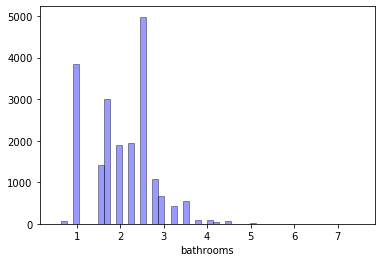

In [44]:
sns.distplot(df_pre['bathrooms'], hist=True, kde=False, 
             bins=int(50), color = 'blue',
             hist_kws={'edgecolor':'black'})

What's a quarter of a bathroom look like? Or three quarters for that matter? I think I can simplify that some. Make the quarters into halves. I figure 2.25 bathrooms is closer to 2.5 than 2.0, but 3.75 bathrooms would also be closer to 3.4 than to 4. So I'll need to edit this column, more like add another column with just halves. I doubt this will help our model, but I don't think it can hurt.

In [45]:
list1=[1,5,9,13,17,21,25,29,33]
list2=[3,7,11,15,19,23,27,31,35]

If the number of bathrooms ends with .25 or .75, multiplying it by 4 (or dividing by .25) results in the numbers in the lists above. All that needs done is run through our dataframe, and change the value if necessary. If not, leave it alone.

In [46]:
df_pre['bath_haf']=df_pre['bathrooms'] #Create a new column for the changed results.

In [47]:
for i in df_pre.index:
    a= df_pre['bath_haf'][i]
    b= a/.25
    if b in list1:
        df_pre['bath_haf'][i]=a + 0.25
    elif b in list2:
        df_pre['bath_haf'][i]= a - 0.25
    else:
        df_pre['bath_haf'][i]= a

In [48]:
df_pre.head()

,sqft_living_log,sqft_lot_log,price_log,price,bedrooms,bathrooms,sqft_living,sqft_lot,bath_haf
0,-1.117789,-0.368636,-1.485162,221900.0,3.0,1.00,1180.0,5650.0,1.0
1,0.810548,-0.091637,0.420131,538000.0,3.0,2.25,2570.0,7242.0,2.5
2,-2.175311,0.268433,-1.935373,180000.0,2.0,1.00,770.0,10000.0,1.0
3,0.139286,-0.505012,0.669074,604000.0,4.0,3.00,1960.0,5000.0,3.0
4,-0.242597,0.030542,0.305147,510000.0,3.0,2.00,1680.0,8080.0,2.0


In [49]:
df_pre['bath_haf'].unique()

array([1. , 2.5, 3. , 2. , 4.5, 1.5, 3.5, 4. , 0.5, 5. , 5.5, 6.5, 7.5])

This probably won't help, but nothing wrong with trying things out.

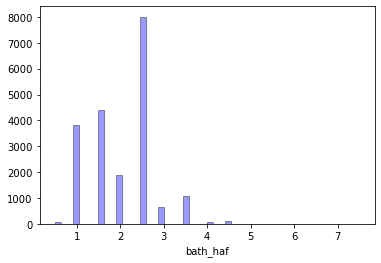

In [50]:
sns.distplot(df_pre['bath_haf'], hist=True, kde=False, 
             bins=int(50), color = 'blue',
             hist_kws={'edgecolor':'black'})

So let's try with this new bathroom data.

In [51]:
att5=['sqft_living_log','sqft_lot_log','bedrooms','bath_haf']

In [52]:
lreg(df_pre[att5],df_pre['price_log'])

Slope: [ 0.65979405 -0.10736254  0.01185104 -0.00294657]
Intercept: -0.033832446322342294
R2 score: 0.4018609379250867


(array([ 0.65979405, -0.10736254,  0.01185104, -0.00294657]),
 -0.033832446322342294,
 0.4018609379250867)

Basically, no difference.

In [53]:
att6=['sqft_living','sqft_lot']

In [54]:
lreg(df_pre[att6],df_pre['price'])

Slope: [ 1.87280232e+02 -9.55323818e-02]
Intercept: 118036.90581137297
R2 score: 0.415067489577291


(array([ 1.87280232e+02, -9.55323818e-02]),
 118036.90581137297,
 0.415067489577291)

Let's try a few more combinations, and see if they yield any better results.

In [55]:
att7=['bedrooms','bath_haf']
lreg(df_pre[att7],df_pre['price'])

Slope: [ 28741.60195985 126620.46384756]
Intercept: 137647.74880899774
R2 score: 0.22521057097961494


(array([ 28741.60195985, 126620.46384756]),
 137647.74880899774,
 0.22521057097961494)

The challenge here is the beds and baths, making the data so it can better fit the model. There's something else I can try:

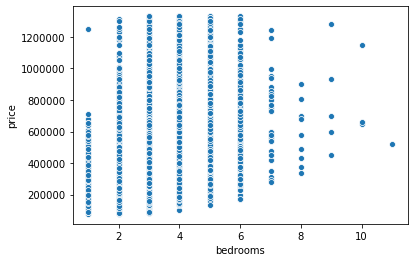

In [56]:
sns.scatterplot(data=df_pre, x="bedrooms", y="price")

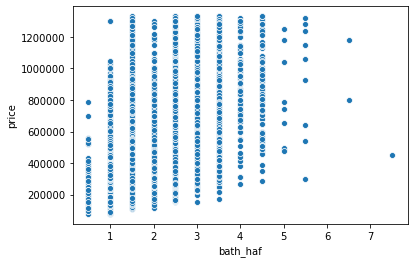

In [57]:
sns.scatterplot(data=df_pre, x="bath_haf", y="price")

In [58]:
df_pre = df_pre[df_pre.bathrooms <= 4]
df_pre = df_pre[df_pre.bedrooms <= 5]  #Setting a cap on the beds and baths

In [59]:
df_pre.groupby(['bedrooms','bath_haf']).size()

bedrooms  bath_haf
1.0       0.5           28
          1.0          135
          1.5           14
          2.0            5
          2.5            6
2.0       0.5           26
          1.0         1552
          1.5          573
          2.0          210
          2.5          284
          3.0           12
          3.5            7
3.0       0.5           16
          1.0         1777
          1.5         2661
          2.0         1023
          2.5         3455
          3.0          166
          3.5          276
          4.0            7
4.0       0.5            3
          1.0          325
          1.5          968
          2.0          521
          2.5         3614
          3.0          293
          3.5          502
          4.0           36
5.0       1.0           43
          1.5          180
          2.0          109
          2.5          565
          3.0          143
          3.5          244
          4.0           29
dtype: int64

The idea here is to take the top three values for each bed/bath combination, much like how we got rid of the quarter bathrooms.

In [60]:
df_pre['bath_3']=df_pre['bath_haf']

In [61]:
#This loop is going to evaluate each entry in the bath_3 and bedrooms column, and if the bathrooms do not fall into the top 3
# values (the group lists), it replaces the value with a null. Then a new dataframe is created without the null values.
for i in df_pre.index:
    group1=[.5,1.0,1.5]
    group23=[1,1.5,2.5]
    group4=[1.5,2,2.5]
    group5=[1.5,2.5,3.5]
    group6=[2.5,3,3.5]
    a= df_pre['bath_3'][i]
    b= df_pre['bedrooms'][i]
    if b == 2 and a not in group23:
        df_pre['bath_3'][i]= None
    elif b == 3 and a not in group23:
        df_pre['bath_3'][i]= None
    elif b == 4 and a not in group4:
        df_pre['bath_3'][i]= None
    elif b == 5 and a not in group5:
        df_pre['bath_3'][i]= None
    elif b == 6 and a not in group6:
        df_pre['bath_3'][i]= None 
    elif b == 1 and a not in group1:
        df_pre['bath_3'][i]= None
df_fin=df_pre.dropna()

In [62]:
df_fin.head()

,sqft_living_log,sqft_lot_log,price_log,price,bedrooms,bathrooms,sqft_living,sqft_lot,bath_haf,bath_3
0,-1.117789,-0.368636,-1.485162,221900.0,3.0,1.00,1180.0,5650.0,1.0,1.0
1,0.810548,-0.091637,0.420131,538000.0,3.0,2.25,2570.0,7242.0,2.5,2.5
2,-2.175311,0.268433,-1.935373,180000.0,2.0,1.00,770.0,10000.0,1.0,1.0
6,-0.191516,-0.158793,-1.165059,257500.0,3.0,2.25,1715.0,6819.0,2.5,2.5
7,-1.383472,0.235710,-0.895667,291850.0,3.0,1.50,1060.0,9711.0,1.5,1.5


In [63]:
df_fin.describe()

,sqft_living_log,sqft_lot_log,price_log,price,bedrooms,bathrooms,sqft_living,sqft_lot,bath_haf,bath_3
count,16571.000000,16571.000000,16571.000000,1.657100e+04,16571.000000,16571.000000,16571.000000,1.657100e+04,16571.000000,16571.000000
mean,0.000071,0.008281,-0.001425,4.720921e+05,3.260576,1.948193,1920.133003,1.394887e+04,1.916782,1.916782
std,0.997856,0.997517,1.001734,2.174486e+05,0.816651,0.624378,728.108550,3.386753e+04,0.651804,0.651804
min,-3.924853,-2.924226,-3.734425,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,0.500000,0.500000
25%,-0.676636,-0.502003,-0.714443,3.090000e+05,3.000000,1.500000,1360.000000,5.170000e+03,1.500000,1.500000
50%,0.036049,-0.043684,-0.007585,4.287500e+05,3.000000,2.000000,1830.000000,7.665000e+03,2.000000,2.000000
75%,0.712228,0.321706,0.723586,5.900000e+05,4.000000,2.500000,2372.500000,1.040000e+04,2.500000,2.500000
max,3.457152,5.966798,2.367255,1.330000e+06,5.000000,3.750000,7350.000000,1.164794e+06,3.500000,3.500000


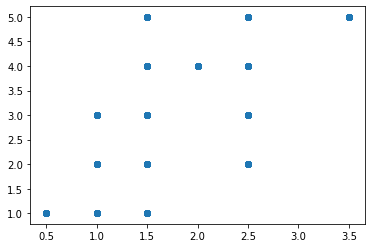

In [64]:
plt.scatter(df_fin['bath_3'],df_fin['bedrooms'])

In [65]:
att8=['bedrooms','bath_3']
lreg(df_fin[att8],df_fin['price'])

Slope: [ 35442.44556322 107749.37766631]
Intercept: 149997.17850212712
R2 score: 0.1694480506121243


(array([ 35442.44556322, 107749.37766631]),
 149997.17850212712,
 0.1694480506121243)

In [66]:
att9=['bedrooms','bath_3','sqft_living_log','sqft_lot_log']
lreg(df_fin[att9],df_fin['price'])

Slope: [ 35384.88298458 107930.76763212  -1723.26741329   1263.95913377]
Intercept: 149826.83614001505
R2 score: 0.16951580426867952


(array([ 35384.88298458, 107930.76763212,  -1723.26741329,   1263.95913377]),
 149826.83614001505,
 0.16951580426867952)

In [67]:
att10=['bedrooms','bath_3','sqft_living_log','sqft_lot_log']
lreg(df_fin[att9],df_fin['price_log'])

Slope: [ 0.01630268 -0.00521318  0.66210583 -0.10790048]
Intercept: -0.04374214022107247
R2 score: 0.4031199903487501


(array([ 0.01630268, -0.00521318,  0.66210583, -0.10790048]),
 -0.04374214022107247,
 0.4031199903487501)

So the best R2 value I got from all these attempts was the very first one:

In [68]:
lreg(df_s1[att1],df_s1['price'])

Slope: [ 3.17701703e+02 -3.87937456e-01 -6.55939211e+04  7.13655709e+03]
Intercept: 91292.7710924244
R2 score: 0.5102382172847046


(array([ 3.17701703e+02, -3.87937456e-01, -6.55939211e+04,  7.13655709e+03]),
 91292.7710924244,
 0.5102382172847046)

Evrything I've done to try to manipulate the data to better fit has only made it worse. There are other things to try, but that will have to wait for another time.

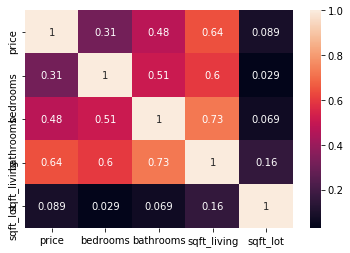

In [69]:
ax = sns.heatmap(df_low1.corr(), annot=True)

ax.set_ylim(5,0)
plt.show()

In [70]:
df_low1.corr().price.sort_values(ascending=False)

price          1.000000
sqft_living    0.644461
bathrooms      0.475228
bedrooms       0.314970
sqft_lot       0.089370
Name: price, dtype: float64

Ok, let's do a train-test split.

In [71]:
X=df_s1[att1]
y=df_s1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [72]:
len(X_test) + len(X_train) == len(X)

True

In [73]:
scaler = StandardScaler()

In [74]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
lr=LinearRegression()
lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")

print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")


Training Scores:
R2: 0.5088084805078192
Testing Scores:
R2: 0.5144807483918121


Again, these numbers do not inspire a lot of confidence in the model. But I think I've done just about as much as I can on manipulating the data. So I'll wrap this up by writing a little code to input those values, and see what comes out.

In [76]:
df_s1.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot
count,2.159600e+04,21596.000000,21596.000000,21596.000000,2.159600e+04
mean,5.402920e+05,3.371828,2.115843,2080.343165,1.509983e+04
std,3.673760e+05,0.904114,0.768998,918.122038,4.141355e+04
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068550e+04
max,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06


In [77]:
m,b,r2=lreg(X,y)

Slope: [ 3.17701703e+02 -3.87937456e-01 -6.55939211e+04  7.13655709e+03]
Intercept: 91292.7710924244
R2 score: 0.5102382172847046


In [78]:
liv_area= float(input("Enter interior square footage (1000-12000): "))

Enter interior square footage (1000-12000): 2000


In [79]:
acre= float(input("Enter lot area (550-1600000): "))

Enter lot area (550-1600000): 1000


In [80]:
nbeds= float(input("Enter number of bedrooms (1-7): "))

Enter number of bedrooms (1-7): 5


In [81]:
nbath= float(input("Enter number of bathrooms (1-8): "))

Enter number of bathrooms (1-8): 2


In [82]:
house= pd.DataFrame([[liv_area,acre,nbeds,nbath]],columns=['sqft_living','sqft_lot','bedrooms','bathrooms'])

In [83]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
sqft_living    1 non-null float64
sqft_lot       1 non-null float64
bedrooms       1 non-null float64
bathrooms      1 non-null float64
dtypes: float64(4)
memory usage: 160.0 bytes


In [84]:
d_price= m*house+b

In [85]:
d_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
sqft_living    1 non-null float64
sqft_lot       1 non-null float64
bedrooms       1 non-null float64
bathrooms      1 non-null float64
dtypes: float64(4)
memory usage: 160.0 bytes


In [86]:
est=sum(d_price.values)

In [87]:
est.tolist()

[726696.1774964968, 90904.83363640675, -236676.83440897788, 105565.88526866068]

In [88]:
est1=sum(est)

In [89]:
print('Estimated price: {}'.format(est1))

Estimated price: 686490.0619925865


So let's put all that into a nice function:

In [98]:
def estimate():
    """This function will allow the user to input 4 values (sqft_living, sqft_lot, bedrooms, and bathrooms) and will receive an
    estimated price based off the linear regression function (lreg) earlier in this program. This function will not operate if
    that function isn't already run with valid values for X and y."""
    m,b,r2=lreg(X,y)
    liv_area= float(input("Enter interior square footage (1000-12000): "))
    acre= float(input("Enter lot area (550-1600000): "))
    nbeds= float(input("Enter number of bedrooms (1-7): "))
    nbath= float(input("Enter number of bathrooms (1-8): "))
    house= pd.DataFrame([[liv_area,acre,nbeds,nbath]],columns=['sqft_living','sqft_lot','bedrooms','bathrooms'])
    d_price= m*house+b
    est=sum(d_price.values)
    est.tolist()
    est1=sum(est)
    print('Estimated price: ${}'.format(round(est1,2)))
    return None

In [100]:
estimate()

Slope: [ 3.17701703e+02 -3.87937456e-01 -6.55939211e+04  7.13655709e+03]
Intercept: 91292.7710924244
R2 score: 0.5102382172847046
Enter interior square footage (1000-12000): 1000
Enter lot area (550-1600000): 1000
Enter number of bedrooms (1-7): 5
Enter number of bathrooms (1-8): 3
Estimated price: $686490.06


## Conclusion:
These models aren't very good. There just isn't a lot of correlation between some of these variables. There's a lot of work left to do, but I'm pretty confident I could make it work, if given enough time. 
### Some ideas to improve: 
Narrowing the scope by zip code, running models for a specific zip code, making that part of the input. I could also narrow the square footage variables a bit more (I noticed quite a range as I was writing the code for the estimator).